## Generator 可以使用 next 來進行循環中的一步
文字上有點難解釋，直接來看範例就能了解什麼是 Generator!

### 撰寫一個 Generator，一次吐出 list 中的一個值

In [1]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i 

In [2]:
my_list = [1, 2, 3, 4, 5]

In [3]:
gen = output_from_list_generator(my_list)

In [4]:
print(next(gen))

1


In [5]:
print(next(gen))

2


In [6]:
print(next(gen))

3


In [7]:
print(next(gen))

4


In [8]:
print(next(gen))

5


In [9]:
print(next(gen))

StopIteration: ignored

### 從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值

### 我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可

In [10]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [11]:
gen = inf_loop_generator(my_list)

In [12]:
print(next(gen))

1


In [13]:
print(next(gen))

2


In [14]:
print(next(gen))

3


In [15]:
print(next(gen))

4


In [16]:
print(next(gen))

5


In [17]:
print(next(gen))

1


In [18]:
print(next(gen))

2


### 上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

## 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [19]:
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [20]:
from keras.datasets import cifar10

In [21]:
(x_train, x_test), (y_train, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [22]:
def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = x_test[indexs: indexs+batch_size]
            yield images, labels

In [23]:
cifar_gen = cifar_generator(x_train)

In [24]:
images, labels = next(cifar_gen)

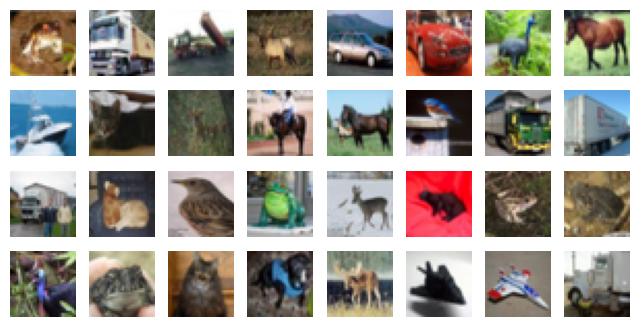

In [25]:
img_combine(images)

In [26]:
images, labels = next(cifar_gen)

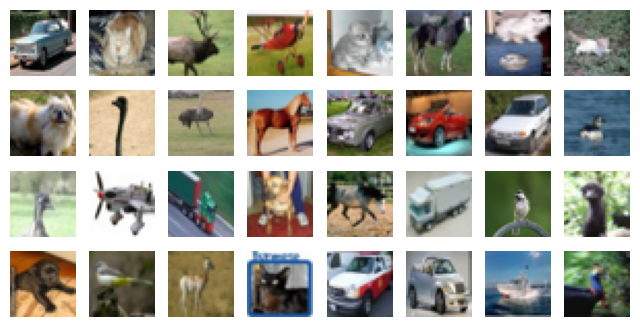

In [27]:
img_combine(images)

## 可以看到兩次的圖片並不一樣，這樣就可以開始訓練囉！

## 作業

請參考昨天的程式碼，將訓練資料讀取方式改寫成 Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。請參考 Keras [官方文件中 fit_generator 的說明](https://keras.io/models/sequential/)

In [28]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [29]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [31]:
from sklearn.utils import shuffle
def my_generator(x, y, batch_size):
    while True:
        for indexs in range(0, len(x), batch_size):
            batch_x, batch_y = x[indexs:indexs+batch_size], y[indexs:indexs+batch_size]
            yield batch_x, batch_y
        x, y = shuffle(x, y) 

In [32]:
train_generator = my_generator(x_train, y_train, batch_size) 

history = model.fit_generator(train_generator,
                    steps_per_epoch=int(len(x_train)/batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10


<ipython-input-32-fc7120ab1aee>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


390/390 [==============================] - 268s 684ms/step - loss: 1.7634 - accuracy: 0.3632 - val_loss: 1.3298 - val_accuracy: 0.5148
Epoch 2/10
390/390 [==============================] - 254s 650ms/step - loss: 1.3155 - accuracy: 0.5330 - val_loss: 1.3611 - val_accuracy: 0.5288
Epoch 3/10
390/390 [==============================] - 254s 651ms/step - loss: 1.0975 - accuracy: 0.6145 - val_loss: 1.0763 - val_accuracy: 0.6263
Epoch 4/10
390/390 [==============================] - 261s 668ms/step - loss: 0.9702 - accuracy: 0.6618 - val_loss: 0.8440 - val_accuracy: 0.7097
Epoch 5/10
390/390 [==============================] - 252s 646ms/step - loss: 0.8760 - accuracy: 0.6968 - val_loss: 0.8866 - val_accuracy: 0.6928
Epoch 6/10
390/390 [==============================] - 259s 665ms/step - loss: 0.8154 - accuracy: 0.7167 - val_loss: 0.7803 - val_accuracy: 0.7306
Epoch 7/10
390/390 [==============================] - 251s 643ms/step - loss: 0.7628 - accuracy: 0.7353 - val_loss: 0.7301 - val_accura